In [1]:
from autolens.data.imaging import image as im
from autolens.data.array import grids, mask as ma
from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp
from autolens.model.galaxy import galaxy as g
from autolens.lensing import ray_tracing
from autolens.lensing import lensing_image as li
from autolens.model.inversion import pixelizations as pix
from autolens.data.imaging.plotters import imaging_plotters
from autolens.model.inversion.plotters import mapper_plotters

# In the previous example, we used a mapper to make a rectangular pixelization. However, it wasn't clear what a mapper
# was actually mapping. Infact, it didn't do much mapping at all! Therefore, in this tutorial, we'll cover mapping.

In [3]:
# To begin, lets simulate and load an image - it'll be clear why we're doing this in a moment.
def simulate():

    from autolens.data.array import grids
    from autolens.model.galaxy import galaxy as g
    from autolens.lensing import ray_tracing

    psf = im.PSF.simulate_as_gaussian(shape=(11, 11), sigma=0.05, pixel_scale=0.05)

    image_plane_grids = grids.DataGrids.grids_for_simulation(shape=(150, 150), pixel_scale=0.05, psf_shape=(11, 11))

    lens_galaxy = g.Galaxy(mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), axis_ratio=0.8, phi=45.0,
                                                        einstein_radius=1.6))
    source_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.0, 0.0), axis_ratio=0.7, phi=135.0, intensity=0.2,
                                                       effective_radius=0.2, sersic_index=2.5))
    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                                 image_plane_grids=[image_plane_grids])

    return im.Image.simulate(array=tracer.image_plane_image_for_simulation, pixel_scale=0.05,
                                        exposure_time=300.0, psf=psf, background_sky_level=0.1, add_noise=True)

image = simulate()
imaging_plotters.plot_image_subplot(image=image)

NoSectionError: No section: 'output'

In [5]:
# Lets begin by setting up our grids (using the image we loaded above).
image_plane_grids = grids.DataGrids.from_shape_and_pixel_scale(shape=image.shape, pixel_scale=image.pixel_scale,
                                                               sub_grid_size=2)

In [6]:
# Our tracer will use the same lens galaxy and source galaxy that we used to simulate the image (although, becuase 
# we're modeling the source with a pixel-grid, we don't need to supply its light profile).
lens_galaxy = g.Galaxy(mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), axis_ratio=0.8, phi=45.0,
                                                    einstein_radius=1.6))
tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[g.Galaxy()],
                                             image_plane_grids=[image_plane_grids])

In [7]:
# Finally, lets setup our pixelization and mapper, like we did before, using the tracer's source-plane grid.
rectangular = pix.Rectangular(shape=(25, 25))
mapper = rectangular.mapper_from_grids_and_border(grids=tracer.source_plane.grids[0], border=None)

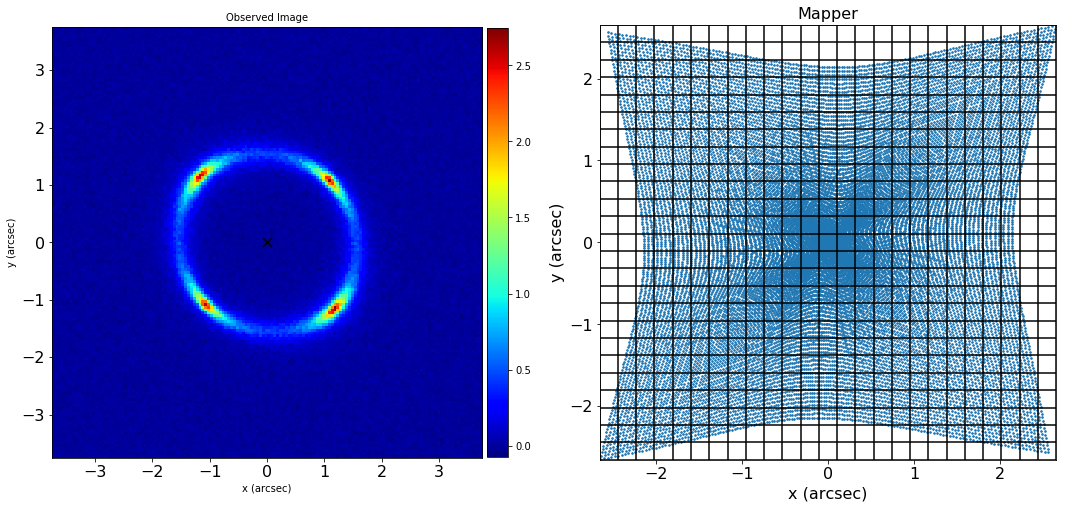

In [9]:
# Again, we're going to plot our mapper, but we're also going to plot the image which was used to generate the grid we
# mapped to the source-plane.
mapper_plotters.plot_image_and_mapper(image=image, mapper=mapper, should_plot_grid=True)

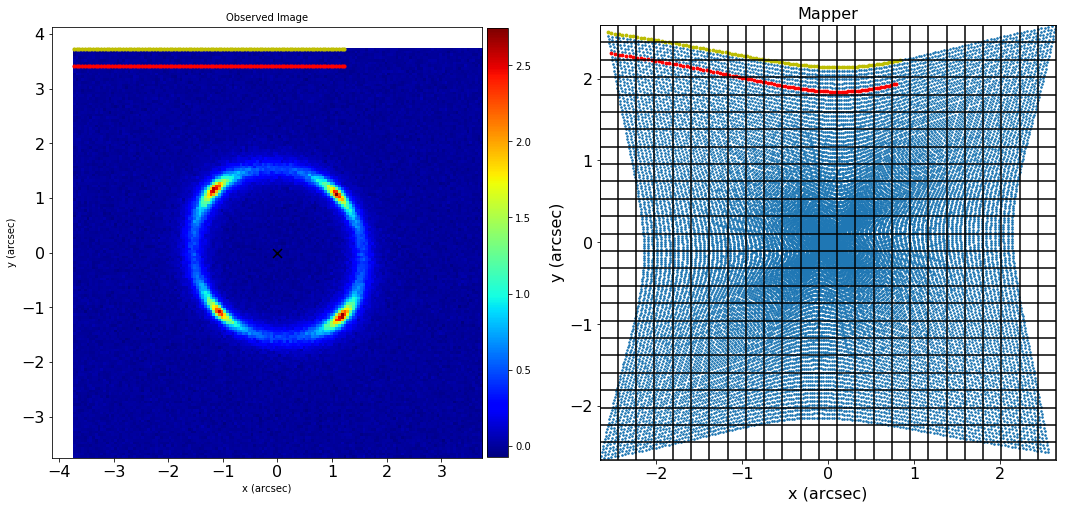

In [11]:
# The pixels in the image map to the pixels in the source-plane, and visa-versa. Lets highlight a set of image-pixels 
# in both the image and source-plane.
mapper_plotters.plot_image_and_mapper(image=image, mapper=mapper, should_plot_grid=True, 
                                      image_pixels=[[range(0, 100)], [range(900, 1000)]])

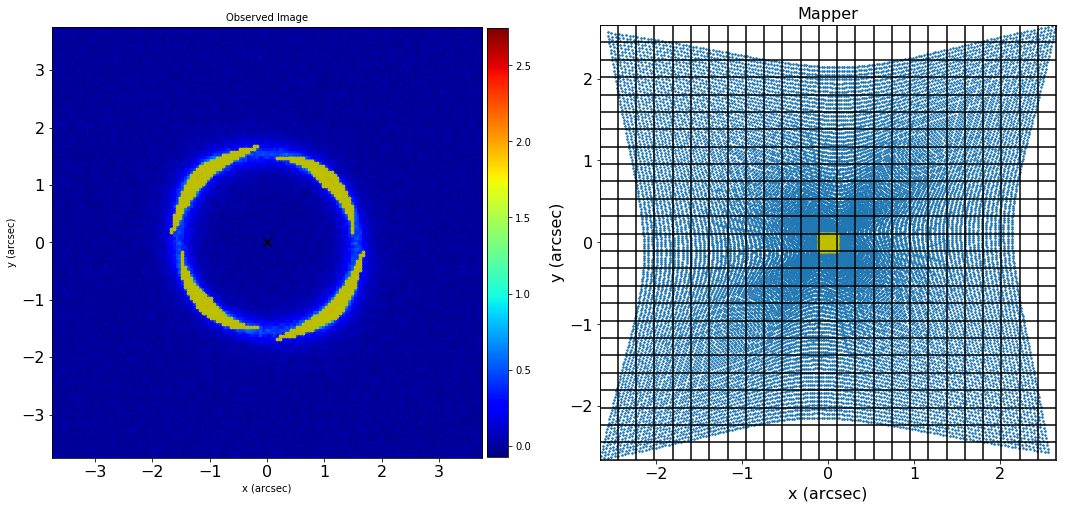

In [12]:
# That's nice, and we can see the mappings, but it isn't really what we want to know, is it? We really want to go the
# other way, and see how our source-pixels map to the image. This is where mappers come into their own, as they let us
# map all the points in a given source-pixel back to the image. Lets map source pixel 313, the central
# source-pixel, to the image.
mapper_plotters.plot_image_and_mapper(image=image, mapper=mapper, should_plot_grid=True, 
                                      source_pixels=[[312]])

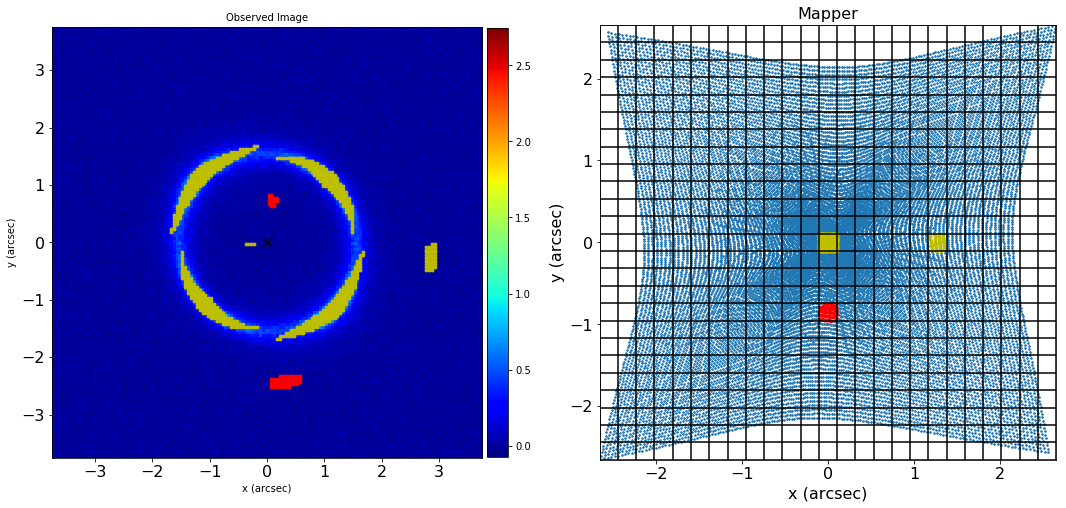

In [13]:
# And there we have it - multiple imaging in all its glory. Try changing the source-pixel indexes of the line below.
# This will give you a feel for how different regions of the source-plane map to the image.
mapper_plotters.plot_image_and_mapper(image=image, mapper=mapper, should_plot_grid=True, 
                                      source_pixels=[[312, 318], [412]])

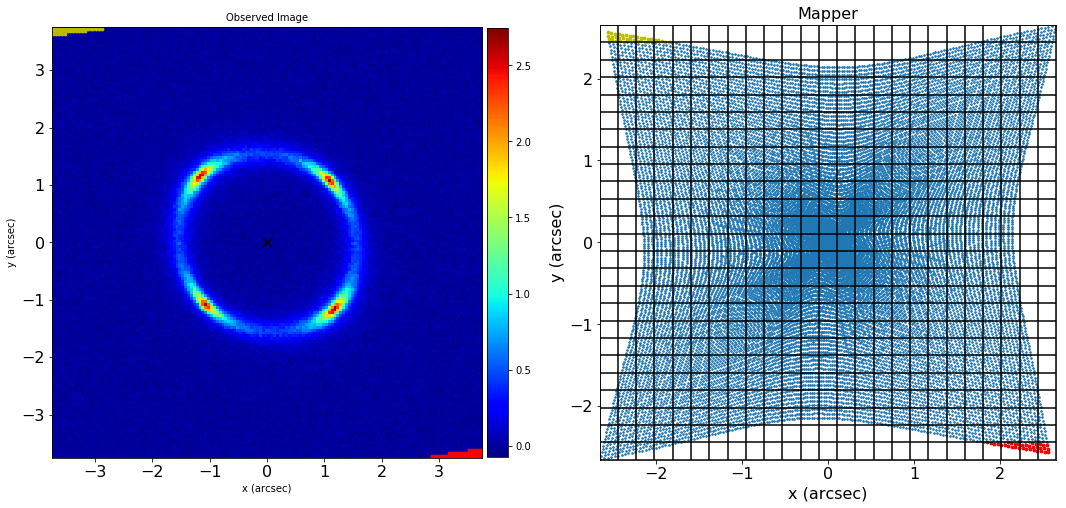

In [14]:
# Okay, so I think we can agree, mappers map things! More specifically, they map our source-plane pixelization to an
# observed image of a strong lens.
#
# Finally, lets do the same as above, but using a masked image. By applying a mask, the mapper will only map
# image-pixels inside the mask. This removes the (many) image pixels at the edge of the image, where the source clearly
# isn't present and which pad-out the size of the source-plane. Lets just have a quick look at these edges pixels:
mapper_plotters.plot_image_and_mapper(image=image, mapper=mapper, should_plot_grid=True, 
                                      source_pixels=[[0, 1, 2, 3, 4, 5, 6, 7], [620, 621, 622, 623, 624]])

In [15]:
# Lets use an annular mask, which will capture the ring-like shape of the lensed source galaxy.
mask = ma.Mask.circular_annular(shape=image.shape, pixel_scale=image.pixel_scale, inner_radius_arcsec=1.0,
                       outer_radius_arcsec=2.2)


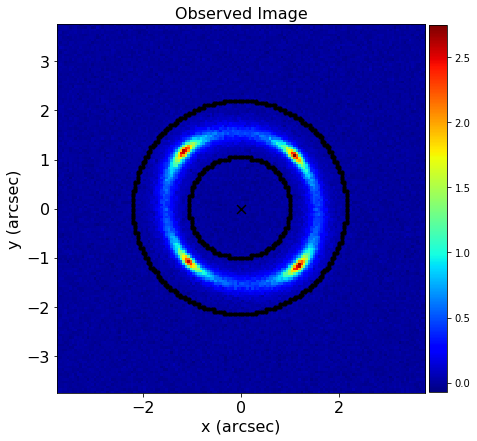

In [16]:
# Lets quickly confirm the annuli radii capture the source's light
imaging_plotters.plot_image(image=image, mask=mask)

In [17]:
# As usual, we setup our image and mask up as a lensing image and create a tracer using its (now masked) grids.
lensing_image = li.LensingImage(image=image, mask=mask)
tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[g.Galaxy()],
                                             image_plane_grids=[lensing_image.grids])

In [18]:
# Finally, we use the tracer's (masked) source-plane grid to setup a new mapper (using the same rectangular 25 x 25
# pixelization as before).
mapper = rectangular.mapper_from_grids_and_border(grids=tracer.source_plane.grids[0], border=None)


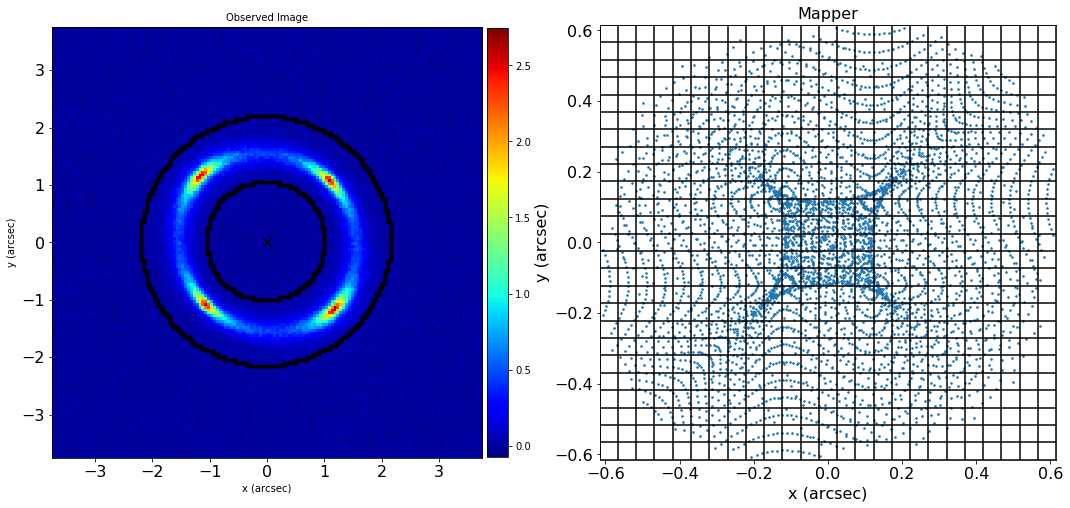

In [19]:
# Lets have another look
mapper_plotters.plot_image_and_mapper(image=image, mask=mask, mapper=mapper, should_plot_grid=True)

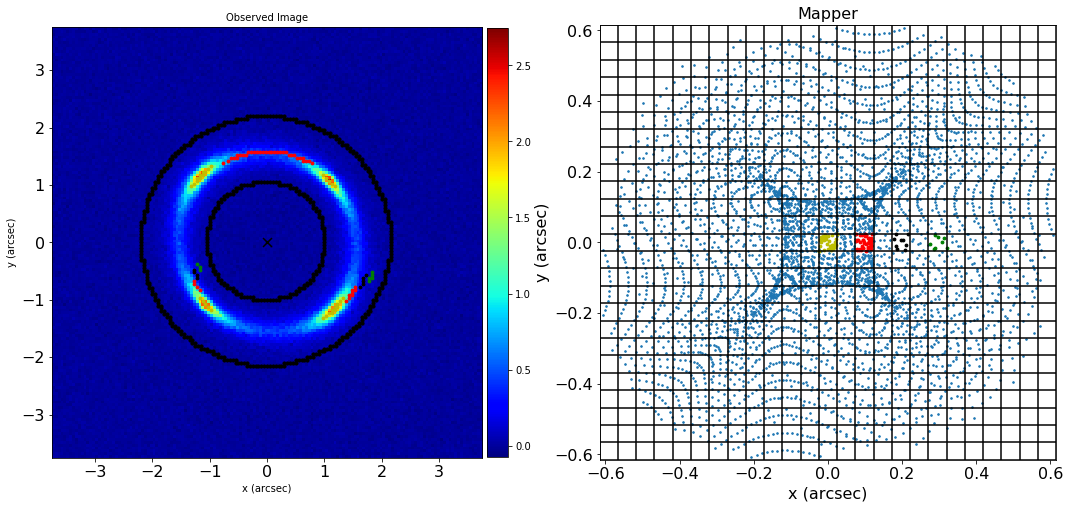

In [20]:
# Woah! Look how much closer we are to the source-plane (The axis sizes have decreased from ~ -2.5" -> 2.5" to 
# ~ -0.6" to 0.6"). We can now really see the diamond of points in the centre of the source-plane (for those who have 
# been reading up, this diamond is called the 'caustic'). This diamond defines when lensing moves from the quadruply 
# imaged regime to doubly-imaged regime, and we can actually show this now using our mapper now.
mapper_plotters.plot_image_and_mapper(image=image, mask=mask, mapper=mapper, should_plot_grid=True, 
                                      source_pixels=[[312], [314], [316], [318]])


In [ ]:
# Great - tutorial 2 down! We've learnt about mappers, which map things, and we used them to understand how the image
# and source plane map to one another. Your exercises are:

# 1) Change the einstein radius of the lens galaxy in small increments (e.g. einstein radius 1.6" -> 1.55").
#    As the radius deviates from 1.6" (the input value of the simulated lens), what do you notice about where the
#    points map from the centre of the source-plane (where the source-galaxy is simulated, e.g. (0.0", 0.0"))?

# 2) Incrementally increase the axis ratio of the lens's mass profile to 1.0. What happens to quadruple imaging?

# 3) Now, finally, think - how is all of this going to help us actually model lenses? We've said we're going to
#    reconstruct our source galaxies on the pixel-grid. So, how does knowing how each pixel maps to the image
#    actually help us? If you've not got any bright ideas, then worry not - that exactly what we're going to cover
#    in the next tutorial.